# Detection and Classification of bone fracture Based on Machine Learning Techniques

### Methodology 
1. Preprocessing
    - **Median** Filter & **Gaussian** Filter for removing salt and pepper noise
    - **Histogram equalization** used for Brightness, Darkness and Contrast Noise  
2. Feature Extraction 
3. ML Algorithms
4. Result & Accuracy 


# Preprocessing

### 1.1 Median & Gaussian Filter

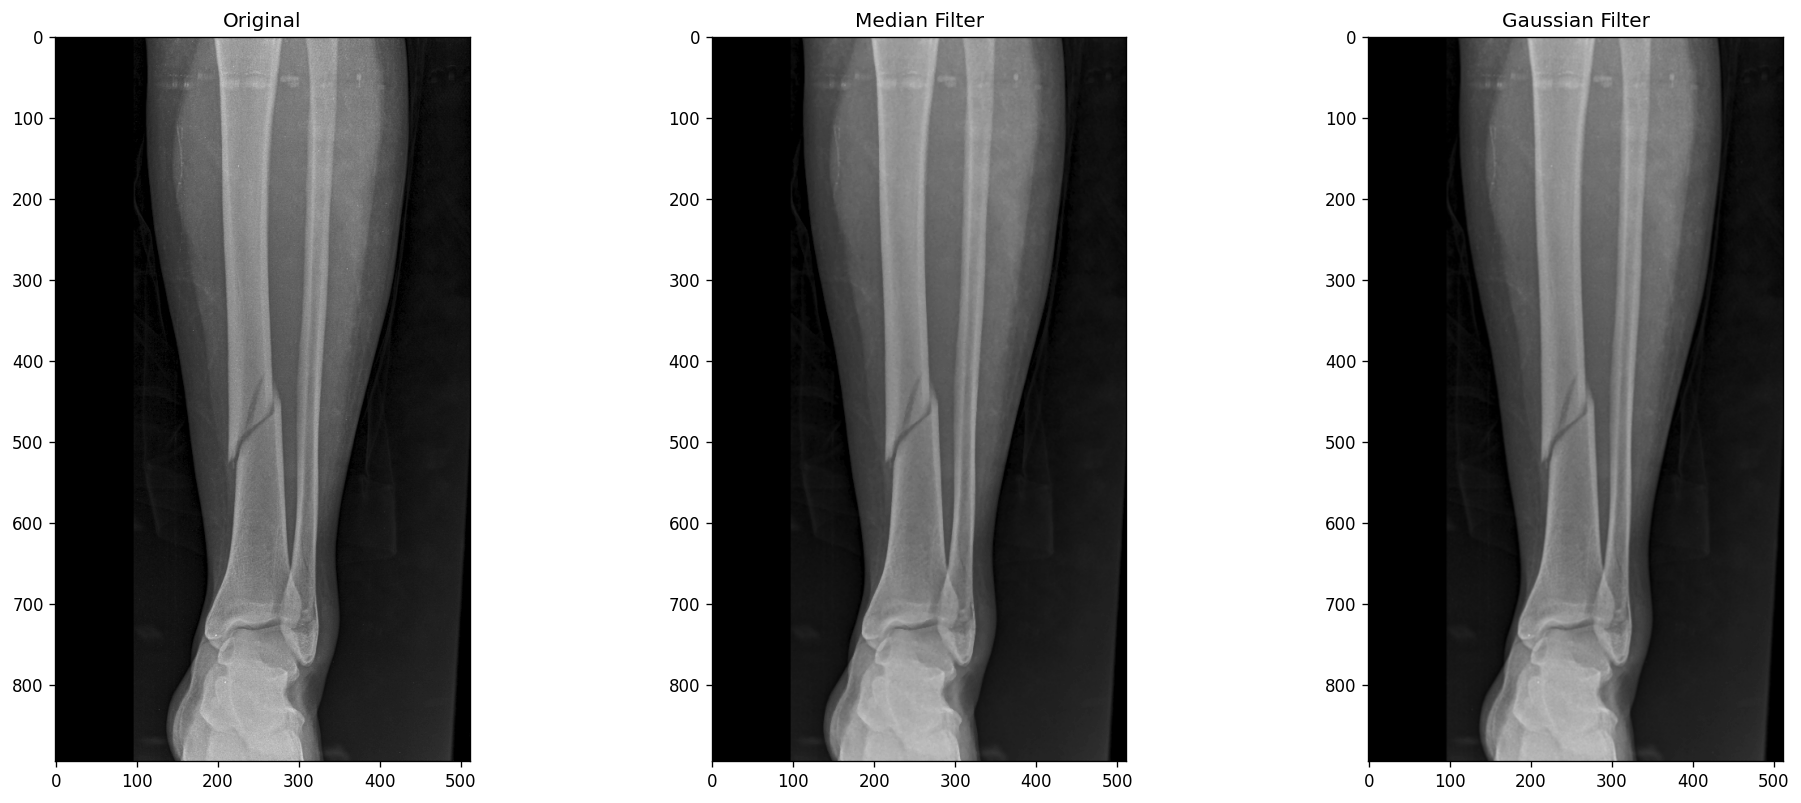

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('../images/sample1.jpg', 0)

median = cv2.medianBlur(img, 3)
gauss = cv2.GaussianBlur(img, (3, 3), 0)

fg, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 8), dpi=120)
ax[2].set_title("Gaussian Filter")
ax[2].imshow(gauss, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Median Filter")
ax[1].imshow(median, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Original")
ax[0].imshow(img, cmap='gray', vmin=0, vmax=255)

### 1.2 Apply Histogram Equalization
[reference](https://medium.com/@kyawsawhtoon/a-tutorial-to-histogram-equalization-497600f270e2)

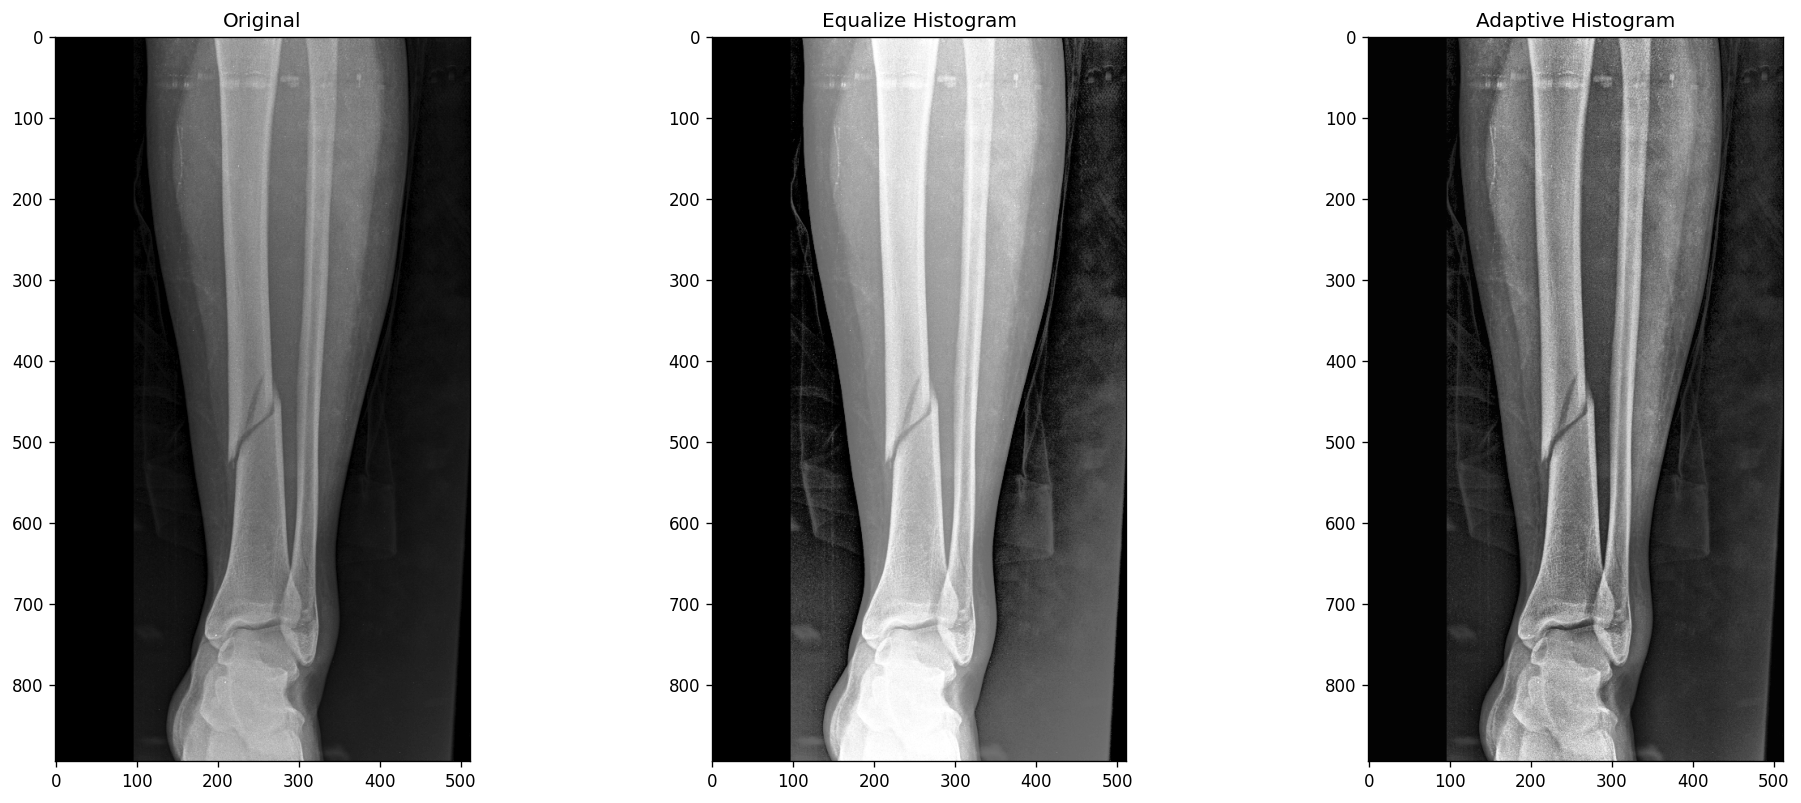

In [2]:
# Histogram Equalization
equalize_hist = cv2.equalizeHist(img)
# Contrastive Limited Adaptive Equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
adaptive_hist = clahe.apply(img)

fge, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 8), dpi=120)
ax[2].set_title("Adaptive Histogram")
ax[2].imshow(adaptive_hist, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Equalize Histogram")
ax[1].imshow(equalize_hist, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Original")
ax[0].imshow(img, cmap='gray', vmin=0, vmax=255)


### 1.3 Bright and Contrast Adjustment

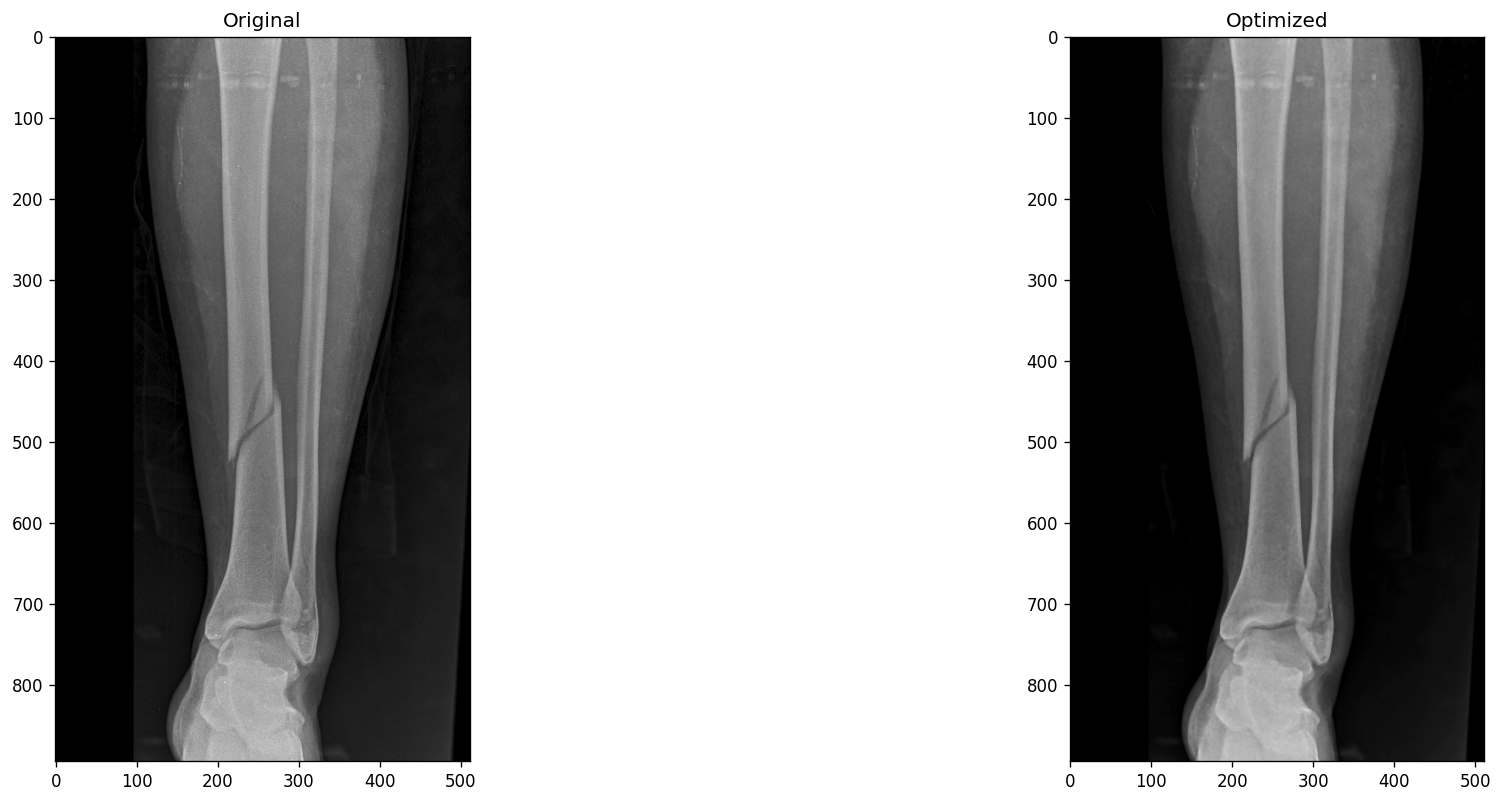

In [3]:
def apply_brightness_contrast(input_img, brightness=0, contrast=0):
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow) / 255
        gamma_b = shadow

        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()

    if contrast != 0:
        f = 131 * (contrast + 127) / (127 * (131 - contrast))
        alpha_c = f
        gamma_c = 127 * (1 - f)

        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf


# img = cv2.imread("images/sample1.jpg", 0)
optimized_img = apply_brightness_contrast(median, brightness=-5, contrast=10)

fgo, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), dpi=120)
ax[1].set_title("Optimized")
ax[1].imshow(optimized_img, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Original")
ax[0].imshow(img, cmap='gray', vmin=0, vmax=255)

# 2. Feature Extraction
### 2.1 Edge Detection

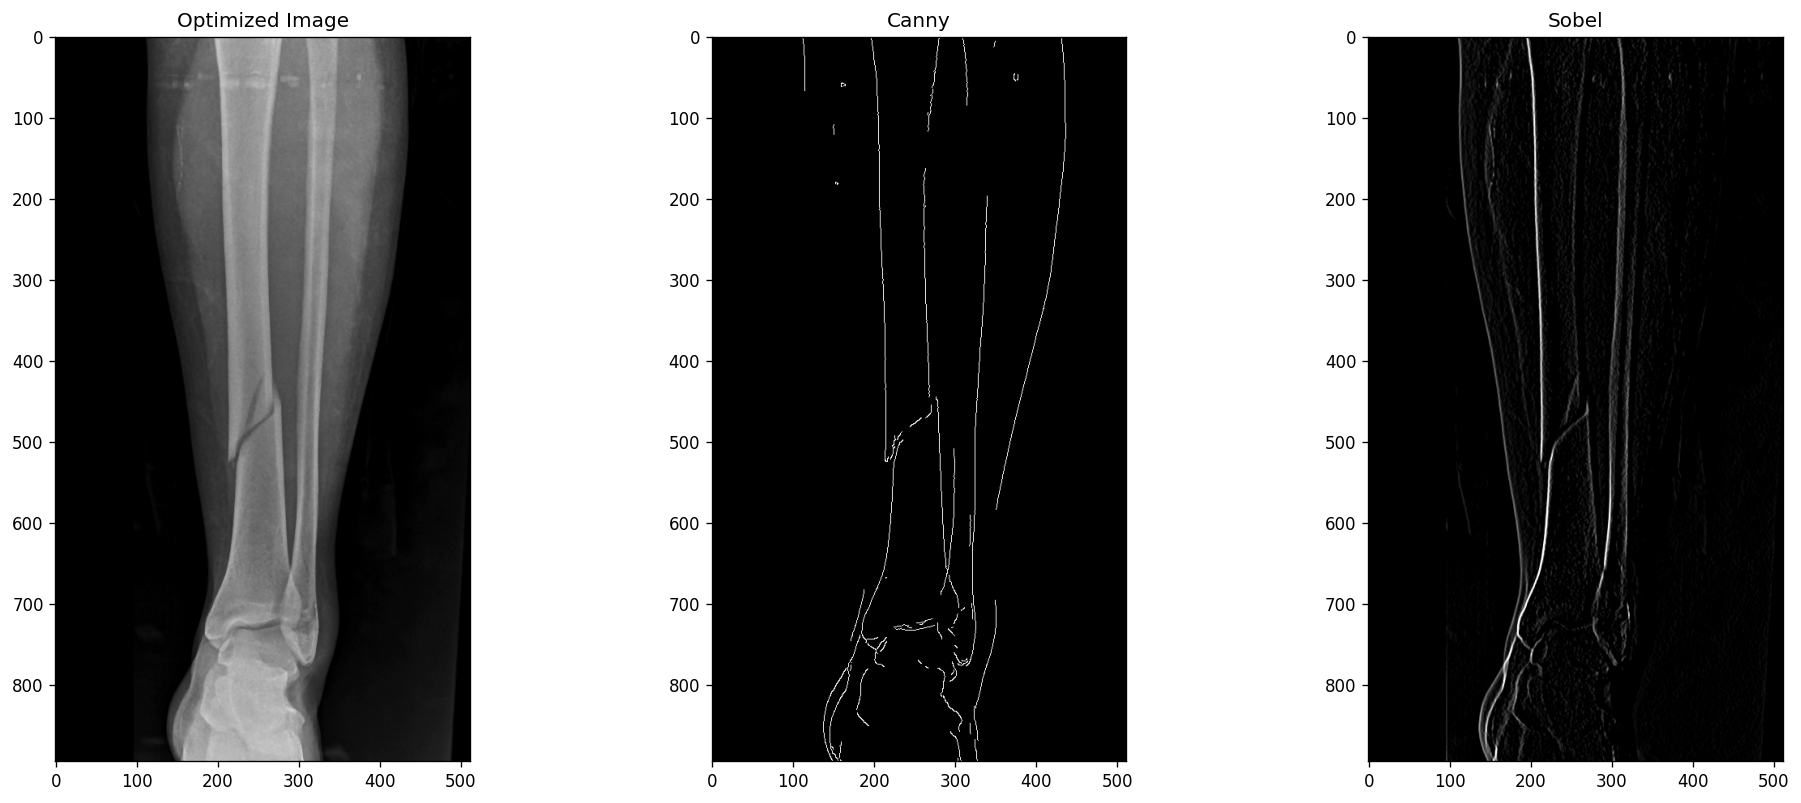

In [4]:
canny = cv2.Canny(optimized_img, 100, 150)
sobel = cv2.Sobel(optimized_img, ddepth=cv2.CV_8U, dx=1, dy=0, ksize=3)

fgc, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 8), dpi=120)
ax[2].set_title("Sobel")
ax[2].imshow(sobel, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Canny")
ax[1].imshow(canny, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Optimized Image")
ax[0].imshow(optimized_img, cmap='gray', vmin=0, vmax=255)

### 2.2 Gray-Level Co-occurrence Matrix(GLCM)

In [1]:
from src.glcm import GLCM
from feature import FeatureExtractor
import cv2

img = cv2.imread('../images/sample1.jpg', 0)

features = FeatureExtractor([img])
image_data = features.glcm_feature_extraction()
####################################################################
print(image_data)

features = GLCM(img)
image_data = features.glcm_all()
####################################################################
print(image_data)

AttributeError: 'FeatureExtractor' object has no attribute 'train_images'

# 3. All Together with ML

## 3.1 Define Preprocessors

In [1]:
from preprocessors import Filter
from bone_fracture import FractureDetector, Ml, DatasetType
from print import print_table

filters = [

    # [Filter.median, Filter.adaptive_hist, Filter.canny],
    [Filter.gaussian, Filter.adaptive_hist, Filter.canny],

    # [ Filter.canny],
    # [ Filter.sobel],

    # [Filter.median, Filter.canny],
    # [Filter.gaussian, Filter.canny],
    # [Filter.median, Filter.sobel],
    # [Filter.gaussian, Filter.sobel], #better on RF

    # [Filter.equalize_hist, Filter.canny],
    # [Filter.adaptive_hist, Filter.canny],
    # [Filter.adjust_contrast, Filter.canny],

    # [Filter.median, Filter.equalize_hist, Filter.canny],
    # [Filter.median, Filter.adaptive_hist, Filter.canny],
    # [Filter.median, Filter.adjust_contrast, Filter.canny],
    # [Filter.median, Filter.equalize_hist, Filter.sobel],
    # [Filter.median, Filter.adaptive_hist, Filter.sobel],
    # [Filter.median, Filter.adjust_contrast, Filter.sobel],
    # [Filter.gaussian, Filter.equalize_hist, Filter.canny],
    # [Filter.gaussian, Filter.adaptive_hist, Filter.canny],
    # [Filter.gaussian, Filter.adjust_contrast, Filter.canny],
    # [Filter.gaussian, Filter.equalize_hist, Filter.sobel],
    # [Filter.gaussian, Filter.adaptive_hist, Filter.sobel],
    # [Filter.gaussian, Filter.adjust_contrast, Filter.sobel],
]

## 3.2 SVM Algorithm

In [2]:
svm_data = []
for _filter in filters:
    detector = FractureDetector(_filter, Ml.svm, dataset=DatasetType.perfect)
    svm_data.append(detector.accuracy())

print("SVM Comparison Table")
print_table(svm_data)


[0.91071429 0.83636364 0.87272727 0.87272727 0.87272727]
0.87 accuracy with a standard deviation of 0.02
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.94      0.98      0.96        46

    accuracy                           0.93        56
   macro avg       0.91      0.84      0.87        56
weighted avg       0.93      0.93      0.93        56

SVM Comparison Table
╒══════════╤═══════════════╤═════════════════╤════════════════╤════════════╕
│ Noise    │ Contrast      │ Edge Detector   │ ML Algorithm   │   Accuracy │
╞══════════╪═══════════════╪═════════════════╪════════════════╪════════════╡
│ Gaussian │ Adaptive Hist │ Canny           │ Svm            │   0.928571 │
╘══════════╧═══════════════╧═════════════════╧════════════════╧════════════╛


## 3.3 Decision Tree Algorithm

In [3]:
dt_data = []
for _filter in filters:
    detector = FractureDetector(_filter, Ml.decision_tree,
                                dataset=DatasetType.perfect)
    dt_data.append(detector.accuracy())

print("Decision Tree Comparison Table")
print_table(dt_data)

[0.85714286 0.74545455 0.87272727 0.8        0.78181818]
0.81 accuracy with a standard deviation of 0.05
              precision    recall  f1-score   support

           0       0.46      0.60      0.52        10
           1       0.91      0.85      0.88        46

    accuracy                           0.80        56
   macro avg       0.68      0.72      0.70        56
weighted avg       0.83      0.80      0.81        56

Decision Tree Comparison Table
╒══════════╤═══════════════╤═════════════════╤════════════════╤════════════╕
│ Noise    │ Contrast      │ Edge Detector   │ ML Algorithm   │   Accuracy │
╞══════════╪═══════════════╪═════════════════╪════════════════╪════════════╡
│ Gaussian │ Adaptive Hist │ Canny           │ Decision Tree  │   0.803571 │
╘══════════╧═══════════════╧═════════════════╧════════════════╧════════════╛


## 3.4 Naive Bayes Algorithm

In [4]:
nb_data = []
for _filter in filters:
    detector = FractureDetector(_filter, Ml.naive_bayes,
                                dataset=DatasetType.perfect)
    nb_data.append(detector.accuracy())

print("Naive Bayes Comparison Table")
print_table(nb_data)

[0.78571429 0.74545455 0.70909091 0.70909091 0.74545455]
0.74 accuracy with a standard deviation of 0.03
              precision    recall  f1-score   support

           0       0.27      0.60      0.37        10
           1       0.88      0.65      0.75        46

    accuracy                           0.64        56
   macro avg       0.58      0.63      0.56        56
weighted avg       0.77      0.64      0.68        56

Naive Bayes Comparison Table
╒══════════╤═══════════════╤═════════════════╤════════════════╤════════════╕
│ Noise    │ Contrast      │ Edge Detector   │ ML Algorithm   │   Accuracy │
╞══════════╪═══════════════╪═════════════════╪════════════════╪════════════╡
│ Gaussian │ Adaptive Hist │ Canny           │ Naive Bayes    │   0.642857 │
╘══════════╧═══════════════╧═════════════════╧════════════════╧════════════╛


## 3.5 Random Forest Algorithm

In [5]:
rf_data = []
for _filter in filters:
    detector = FractureDetector(_filter, Ml.random_forest,
                                dataset=DatasetType.perfect)
    rf_data.append(detector.accuracy())

print("Random Forest Comparison Table")
print_table(rf_data)

[0.875      0.85454545 0.89090909 0.83636364 0.85454545]
0.86 accuracy with a standard deviation of 0.02
              precision    recall  f1-score   support

           0       0.50      0.40      0.44        10
           1       0.88      0.91      0.89        46

    accuracy                           0.82        56
   macro avg       0.69      0.66      0.67        56
weighted avg       0.81      0.82      0.81        56

Random Forest Comparison Table
╒══════════╤═══════════════╤═════════════════╤════════════════╤════════════╕
│ Noise    │ Contrast      │ Edge Detector   │ ML Algorithm   │   Accuracy │
╞══════════╪═══════════════╪═════════════════╪════════════════╪════════════╡
│ Gaussian │ Adaptive Hist │ Canny           │ Random Forest  │   0.821429 │
╘══════════╧═══════════════╧═════════════════╧════════════════╧════════════╛


## 3.6 Nearest Neighbors Algorithm

In [6]:
nn_data = []
for _filter in filters:
    detector = FractureDetector(_filter, Ml.nearest_neighbors,
                                dataset=DatasetType.perfect)
    nn_data.append(detector.accuracy())

print("Nearest Neighbors Comparison Table")
print_table(nn_data)

[0.80357143 0.8        0.8        0.8        0.8       ]
0.80 accuracy with a standard deviation of 0.00
              precision    recall  f1-score   support

           0       0.50      0.30      0.37        10
           1       0.86      0.93      0.90        46

    accuracy                           0.82        56
   macro avg       0.68      0.62      0.64        56
weighted avg       0.80      0.82      0.80        56

Nearest Neighbors Comparison Table
╒══════════╤═══════════════╤═════════════════╤═══════════════════╤════════════╕
│ Noise    │ Contrast      │ Edge Detector   │ ML Algorithm      │   Accuracy │
╞══════════╪═══════════════╪═════════════════╪═══════════════════╪════════════╡
│ Gaussian │ Adaptive Hist │ Canny           │ Nearest Neighbors │   0.821429 │
╘══════════╧═══════════════╧═════════════════╧═══════════════════╧════════════╛


Fracture Detector - ML Algorithms Comparison Table
╒══════════╤═══════════════╤═════════════════╤═══════════════════╤════════════╕
│ Noise    │ Contrast      │ Edge Detector   │ ML Algorithm      │   Accuracy │
╞══════════╪═══════════════╪═════════════════╪═══════════════════╪════════════╡
│ Gaussian │ Adaptive Hist │ Canny           │ Svm               │   0.910714 │
├──────────┼───────────────┼─────────────────┼───────────────────┼────────────┤
│ Gaussian │ Adaptive Hist │ Canny           │ Decision Tree     │   0.785714 │
├──────────┼───────────────┼─────────────────┼───────────────────┼────────────┤
│ Gaussian │ Adaptive Hist │ Canny           │ Naive Bayes       │   0.803571 │
├──────────┼───────────────┼─────────────────┼───────────────────┼────────────┤
│ Gaussian │ Adaptive Hist │ Canny           │ Random Forest     │   0.910714 │
├──────────┼───────────────┼─────────────────┼───────────────────┼────────────┤
│ Gaussian │ Adaptive Hist │ Canny           │ Nearest Neighbors │   

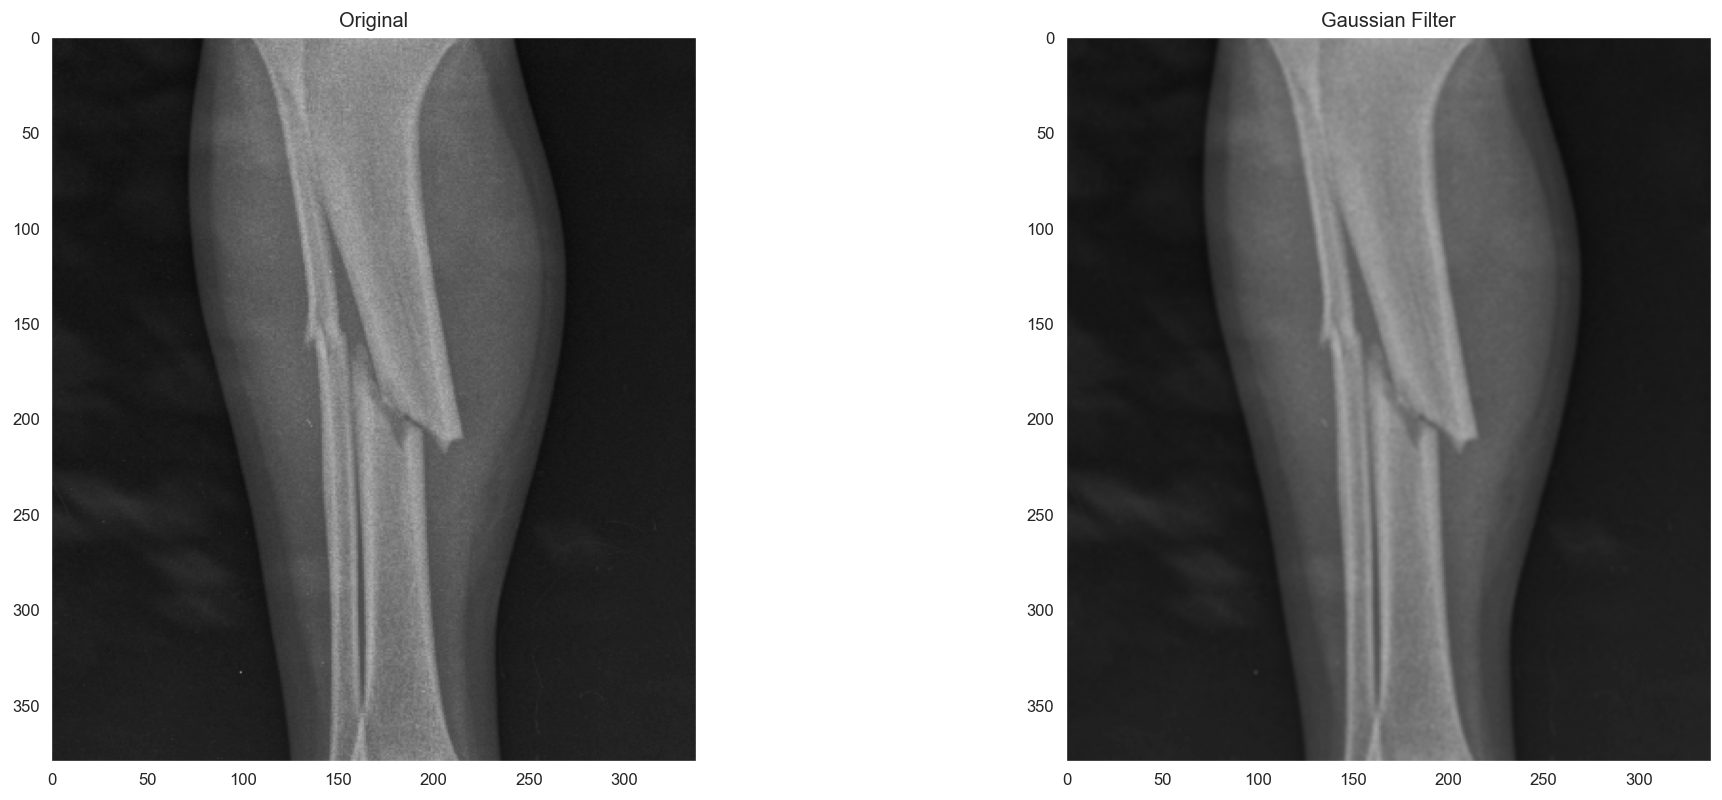

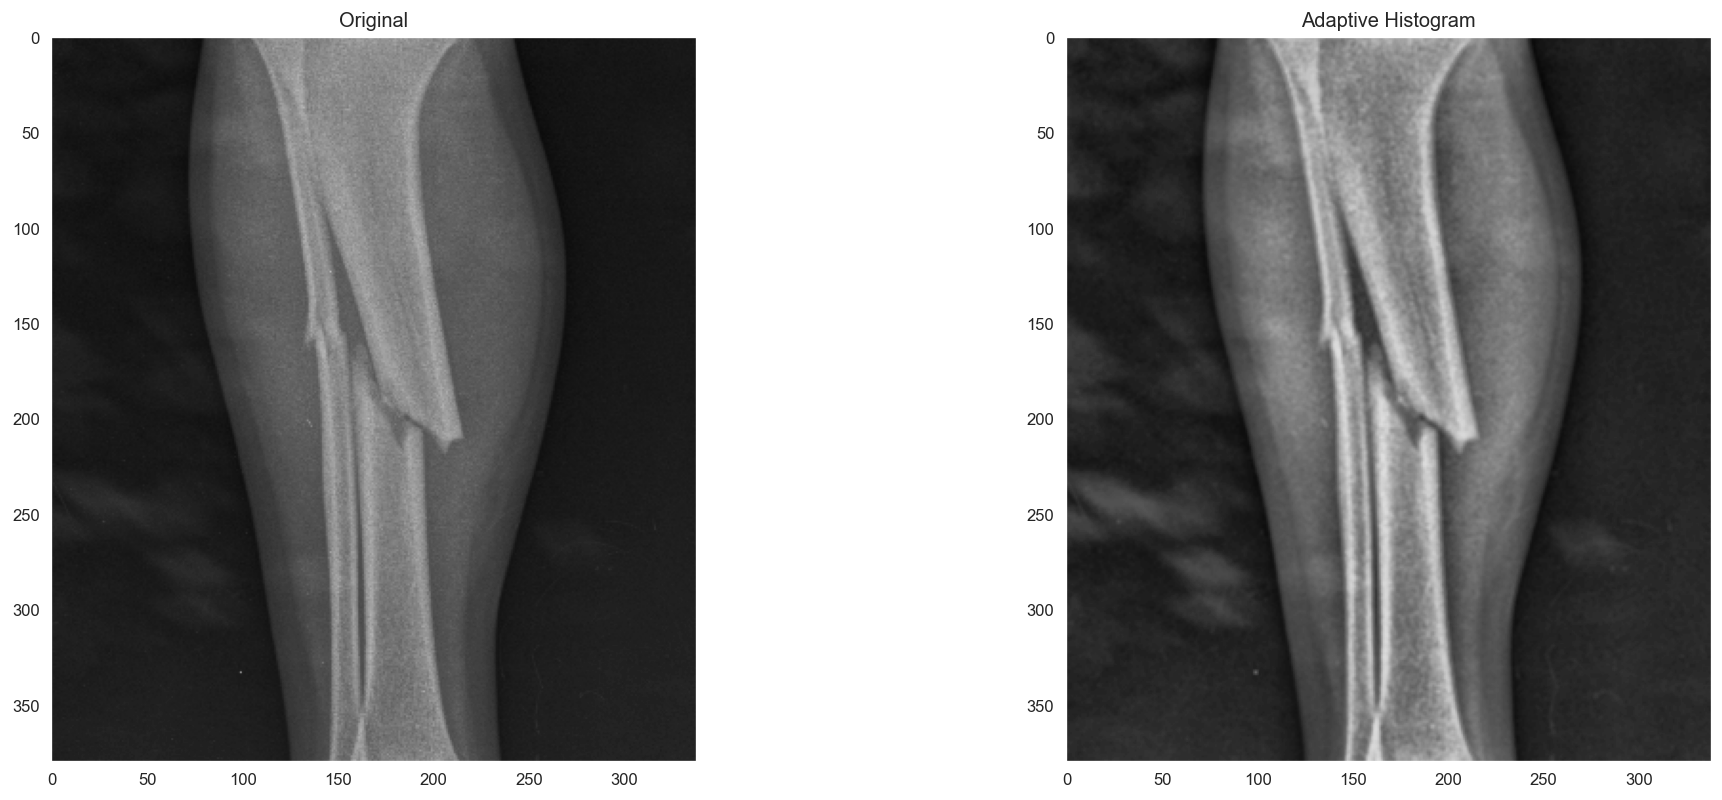

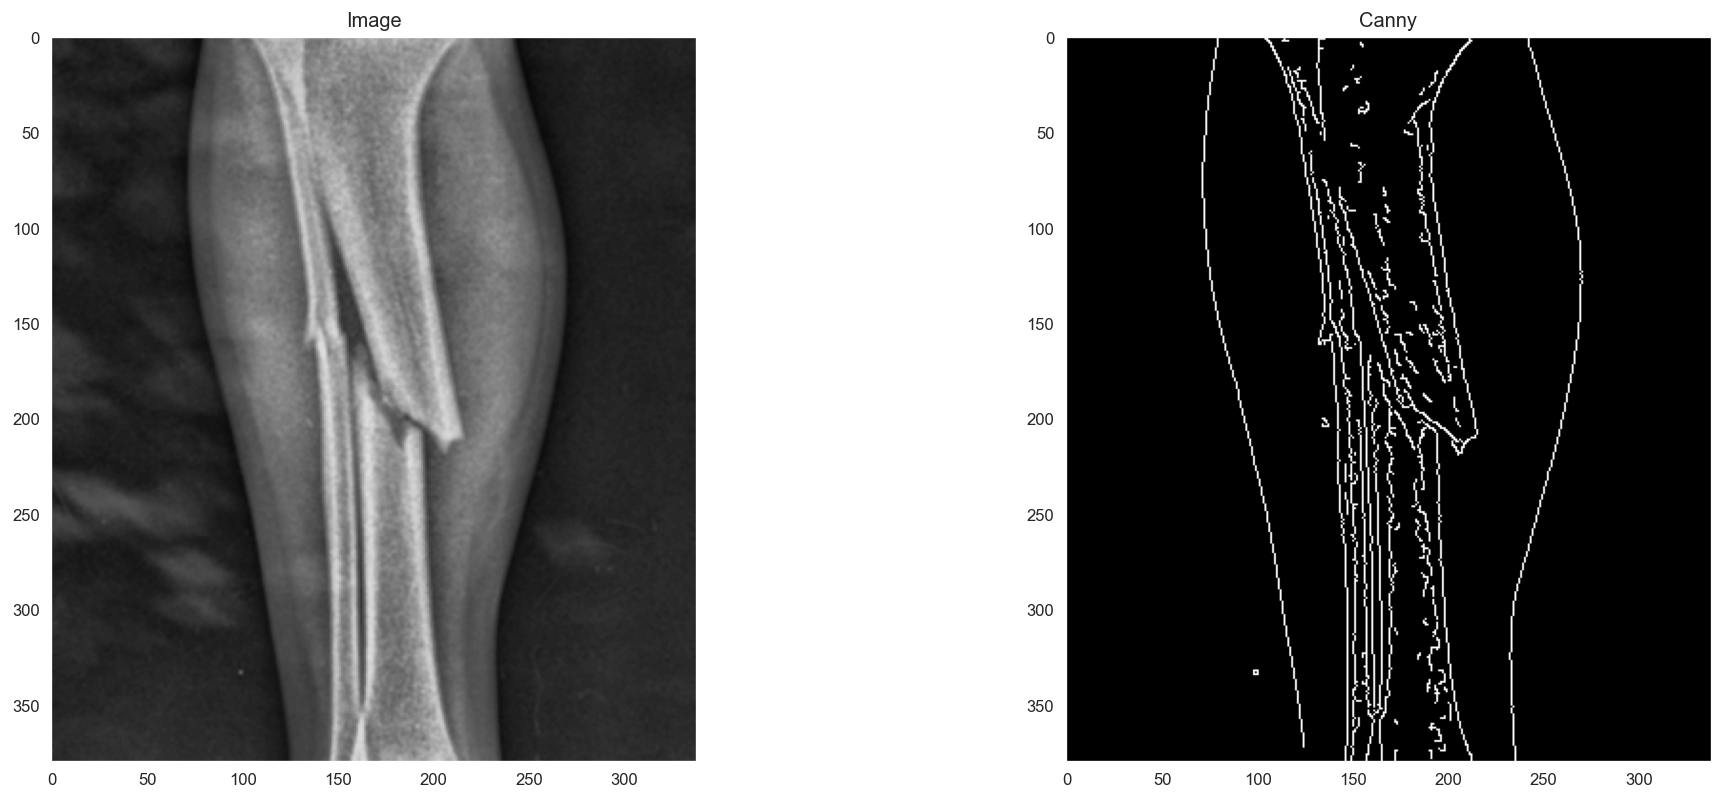

In [1]:
from preprocessors import Filter
from bone_fracture import FractureDetector, Ml, DatasetType
from print import print_table
import cv2
from matplotlib import pyplot as plt
from feature import FeatureExtractor

# Load an image to apply preprocessing filters
# 1. Noise Cancellation
img = cv2.imread('../images/perfect_images/fractured/73.jpg', 0)
gauss = cv2.GaussianBlur(img, (3, 3), 0)

fg, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), dpi=120)
ax[0].set_title("Original")
ax[0].grid(False)
ax[0].imshow(img, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Gaussian Filter")
ax[1].grid(False)
ax[1].imshow(gauss, cmap='gray', vmin=0, vmax=255)

# 2. Contrast Improvement
# Contrastive Limited Adaptive Equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
adaptive_hist = clahe.apply(gauss)

fge, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), dpi=120)
ax[0].set_title("Original")
ax[0].grid(False)
ax[0].imshow(img, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Adaptive Histogram")
ax[1].grid(False)
ax[1].imshow(adaptive_hist, cmap='gray', vmin=0, vmax=255)

# 3. Edge Detection
canny = cv2.Canny(adaptive_hist, 100, 150)

fgc, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), dpi=120)
ax[0].set_title("Image")
ax[0].grid(False)
ax[0].imshow(adaptive_hist, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Canny")
ax[1].grid(False)
ax[1].imshow(canny, cmap='gray', vmin=0, vmax=255)

# 4. Feature Extraction
# features = FeatureExtractor(canny)
# print(features.single_glcm_feature_extraction())

# 5. Apply ML Algorithms
# Define filters and dataset.
filters = [Filter.gaussian, Filter.adaptive_hist, Filter.canny]
dataset = DatasetType.perfect
result = []

# SVM Algorithm
detector = FractureDetector(filters, Ml.svm, dataset=dataset)
result.append(detector.accuracy())

# Decision Tree Algorithm
detector = FractureDetector(filters, Ml.decision_tree, dataset=dataset)
result.append(detector.accuracy())

# Naive Bayes Algorithm
detector = FractureDetector(filters, Ml.naive_bayes, dataset=dataset)
result.append(detector.accuracy())

# Random Forest Algorithm
detector = FractureDetector(filters, Ml.random_forest, dataset=dataset)
result.append(detector.accuracy())

# Nearest Neighbors Algorithm
detector = FractureDetector(filters, Ml.nearest_neighbors, dataset=dataset)
result.append(detector.accuracy())

print("Fracture Detector - ML Algorithms Comparison Table")
print_table(result)

# 4 Data Augmentation

## 4.1 Generate Data

In [8]:
# import albumentations as A
# import cv2
#
#
# def visualize(image):
#     plt.figure(figsize=(10, 10))
#     plt.axis('off')
#     plt.imshow(image)
#
#
# image = cv2.imread('../images/sample1.jpg', 0)
# # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#
# transform = A.Compose(
#     [
#         # A.CLAHE(),
#         # A.VerticalFlip(p=1),
#         # A.HorizontalFlip(p=1),
#         # A.Transpose(),
#         A.ShiftScaleRotate(p=0.5, scale_limit=0.01)
#         # A.ShiftScaleRotate(shift_limit=0, scale_limit=0.6,
#         #                    rotate_limit=0, p=0.8),
#         # A.Blur(blur_limit=3),
#         # A.OpticalDistortion(),
#         # A.GridDistortion(),
#         # A.HueSaturationValue()
#     ])
#
# augmented_image = transform(image=image)['image']
# visualize(augmented_image)

from keras.preprocessing.image import ImageDataGenerator
from skimage import io
import numpy as np
from PIL import Image
import os

datagen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

image_directory = '../images/perfect_images/non-fractured/'
SIZE = 254
dataset = []
my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):
    if image_name.split('.')[1] == 'jpg':
        image = io.imread(image_directory + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))

x = np.array(dataset)
i = 0
iterator = datagen.flow(x, batch_size=16,
                        save_to_dir=r'../images/aug_perfect_images/non-fractured',
                        save_prefix='dr',
                        save_format='jpg')
for batch in iterator:
    i += 1
    if i > 100:
        break

## 4.2 Test Generated Data

In [10]:
from preprocessors import Filter
from bone_fracture import FractureDetector, Ml, DatasetType
from print import print_table

filters = [
    [Filter.median, Filter.canny],
    # [Filter.median, Filter.equalize_hist, Filter.canny],
    # [Filter.median, Filter.adaptive_hist, Filter.canny],
    # [Filter.median, Filter.adjust_contrast, Filter.canny],
    # [Filter.median, Filter.equalize_hist, Filter.sobel],
    # [Filter.median, Filter.adaptive_hist, Filter.sobel],
    # [Filter.median, Filter.adjust_contrast, Filter.sobel],
    # [Filter.gaussian, Filter.equalize_hist, Filter.canny],
    # [Filter.gaussian, Filter.adaptive_hist, Filter.canny],
    # [Filter.gaussian, Filter.adjust_contrast, Filter.canny],
    # [Filter.gaussian, Filter.equalize_hist, Filter.sobel],
    # [Filter.gaussian, Filter.adaptive_hist, Filter.sobel],
    # [Filter.gaussian, Filter.adjust_contrast, Filter.sobel],
]

nb_data = []
for _filter in filters:
    detector = FractureDetector(_filter, Ml.random_forest,
                                dataset=DatasetType.augmented)
    nb_data.append(detector.accuracy())

print("Naive Bayes Comparison Table")
print_table(nb_data)

Naive Bayes Comparison Table
╒═════════╤════════════╤═════════════════╤════════════════╕
│ Noise   │ Contrast   │ Edge Detector   │   ML Algorithm │
╞═════════╪════════════╪═════════════════╪════════════════╡
│ Median  │ Canny      │ Random Forest   │       0.827974 │
╘═════════╧════════════╧═════════════════╧════════════════╛


# Experimental Tests

In [14]:
from preprocessors import Filter
from bone_fracture import FractureDetector, Ml
from print import print_table
import glob

filters = [
    # [Filter.median, Filter.equalize_hist, Filter.canny],
    # [Filter.median, Filter.adaptive_hist, Filter.canny],
    # [Filter.median, Filter.adjust_contrast, Filter.canny],
    # [Filter.median, Filter.equalize_hist, Filter.sobel],
    # [Filter.median, Filter.adaptive_hist, Filter.sobel],
    # [Filter.median, Filter.adjust_contrast, Filter.sobel],
    [Filter.gaussian, Filter.equalize_hist, Filter.canny],
    # [Filter.gaussian, Filter.adaptive_hist, Filter.canny],
    # [Filter.gaussian, Filter.adjust_contrast, Filter.canny],
    # [Filter.gaussian, Filter.equalize_hist, Filter.sobel],
    # [Filter.gaussian, Filter.adaptive_hist, Filter.sobel],
    # [Filter.gaussian, Filter.adjust_contrast, Filter.sobel],
]

for img_path in glob.glob('../images/test/fractured/*.jpg'):
    os.rename()
    printable_data = []
    for _filter in filters:
        detector = FractureDetector(_filter, Ml.random_forest)
        printable_data.append(detector.predict(img_path))

    print("Image: " + img_path.split('/')[-1])
    print_table(printable_data)

../images/augmented_train/non-fractured/11_24_2021-5_56_44 AM-348.jpg
../images/augmented_train/non-fractured/1.jpg
../images/augmented_train/non-fractured/11_14_2021-8_20_36 AM-663.jpg
../images/augmented_train/non-fractured/2.jpg
../images/augmented_train/non-fractured/11_23_2021-7_30_25 PM-824.jpg
../images/augmented_train/non-fractured/3.jpg
../images/augmented_train/non-fractured/11_24_2021-5_57_15 AM-273.jpg
../images/augmented_train/non-fractured/4.jpg
../images/augmented_train/non-fractured/11_17_2021-6_24_25 AM-81.jpg
../images/augmented_train/non-fractured/5.jpg
../images/augmented_train/non-fractured/12_7_2021-5_56_12 AM-989.jpg
../images/augmented_train/non-fractured/6.jpg
../images/augmented_train/non-fractured/11_11_2021-8_54_52 PM-633.jpg
../images/augmented_train/non-fractured/7.jpg
../images/augmented_train/non-fractured/11_20_2021-11_02_42 PM-5811.jpg
../images/augmented_train/non-fractured/8.jpg
../images/augmented_train/non-fractured/11_17_2021-6_23_56 AM-809.jpg
..